In [13]:
import datasets
from transformers import BertForSequenceClassification, BertModel, BertTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

## Load and Analyze Data

In [2]:
data = datasets.load_dataset("tweet_eval", "sentiment")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

### Plotting label distribution of the splits.

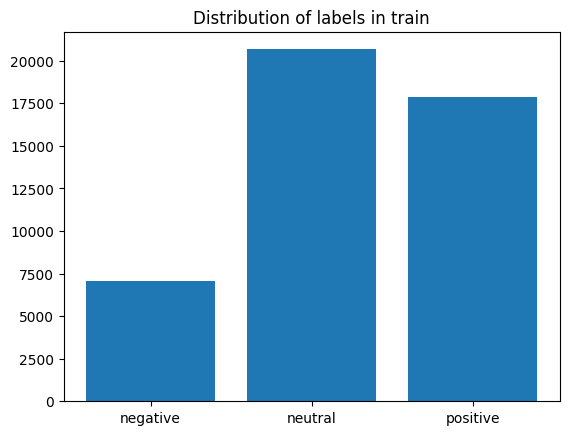

train [7093, 20673, 17849]


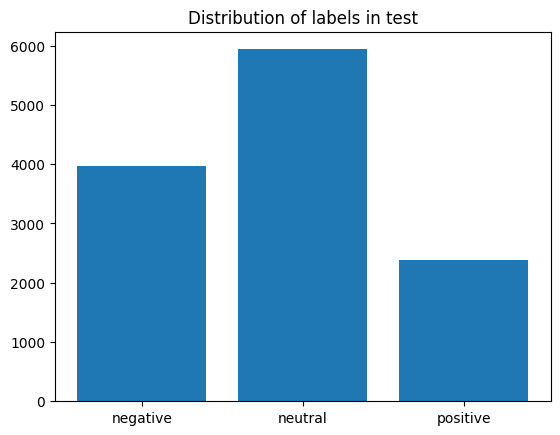

test [3972, 5937, 2375]


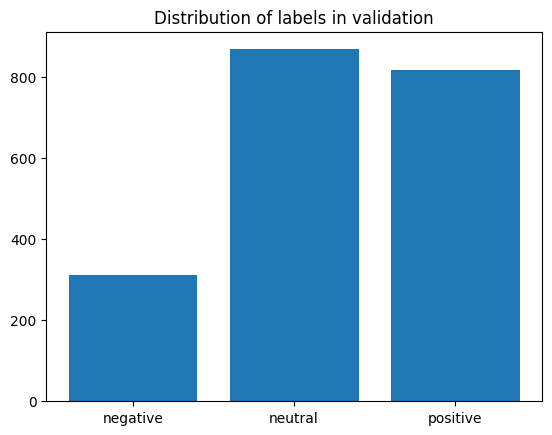

validation [312, 869, 819]


In [4]:
splits = ['train', 'test', 'validation']
#split = splits[2]

def plot_distr(split):
    fig = plt.figure()
    label_counts = data[split]['label']
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels in ' + split)
    plt.show()

    print(split, label_counts)
    
for s in splits:
    plot_distr(s)

### Get splits

In [5]:
X_train, y_train = data['train']['text'], data['train']['label']
X_val, y_val = data['validation']['text'], data['validation']['label']
X_test, y_test = data['test']['text'], data['test']['label']

### Downsampling the splits

In [7]:
def down_sample(X, y):
    label_count = [y.count(i) for i in range(3)]
    min_count = min(label_count)
    
    XY = np.array(list(zip(X, y)))
    
    downsampled = []
    for i in range(3):
        label = XY[XY[:, 1] == str(i)]
        np.random.shuffle(label)
        downsampled.append(label[:min_count])
    
    downsampled = np.concatenate(downsampled)
    np.random.shuffle(downsampled)
    
    return list(downsampled[:, 0]), [int(x) for x in downsampled[:, 1]]

In [8]:
X_train_sample, y_train_sample = down_sample(X_train, y_train)
X_val_sample, y_val_sample = down_sample(X_val, y_val)
X_test_sample, y_test_sample = down_sample(X_test, y_test)

### Plot label distributions after downsampling

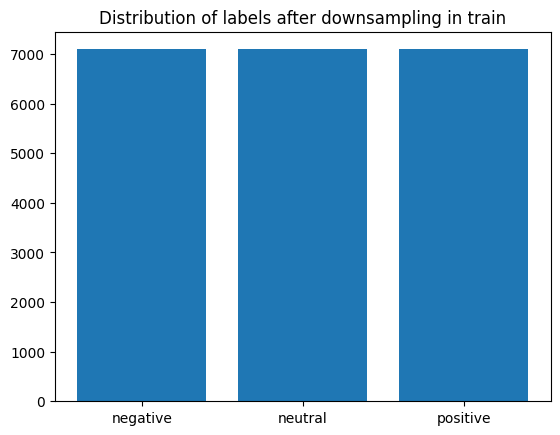

train [7093, 7093, 7093]


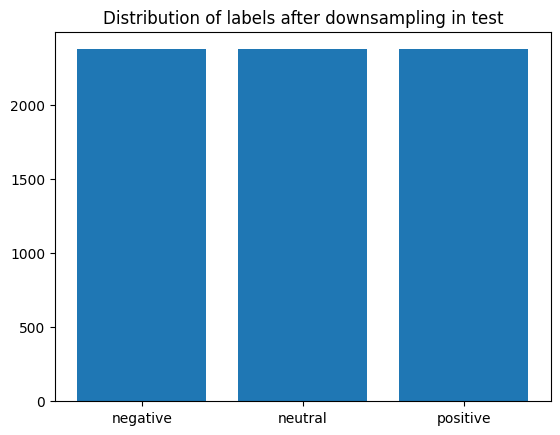

test [2375, 2375, 2375]


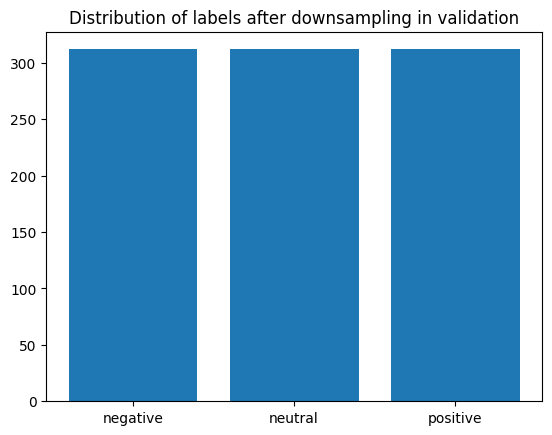

validation [312, 312, 312]


In [9]:
def plot_distr_sample(X, y, split):
    fig = plt.figure()
    label_counts = y
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels after downsampling in ' + split)
    plt.show()

    print(split, label_counts)
    
plot_distr_sample(X_train_sample, y_train_sample, 'train')
plot_distr_sample(X_test_sample, y_test_sample, 'test')
plot_distr_sample(X_val_sample, y_val_sample, 'validation')


## Finetune BERT Model

### Initialize the model

In [55]:
bertsc = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


train_encodings = tokenizer(X_train_sample, truncation=True, padding=True)
val_encodings = tokenizer(X_val_sample, truncation=True, padding=True)
test_encodings = tokenizer(X_test_sample, truncation=True, padding=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare data and metrics

In [58]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TweetDataset(train_encodings, y_train_sample)
val_dataset = TweetDataset(val_encodings, y_val_sample)
test_dataset = TweetDataset(test_encodings, y_test_sample)

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def _compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro')
    acc = accuracy_score(labels, pred)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

### Training

In [12]:
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./results/logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    fp16=True
    
)

trainer = Trainer(
    model=bertsc,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=_compute_metrics
)

trainer.train()

 20%|██        | 2660/13300 [08:30<32:04,  5.53it/s]

{'loss': 0.8028, 'grad_norm': 10.687106132507324, 'learning_rate': 4.1574218750000006e-05, 'epoch': 1.0}


                                                    
 20%|██        | 2660/13300 [08:34<32:04,  5.53it/s]

{'eval_loss': 0.702452540397644, 'eval_accuracy': 0.6987179487179487, 'eval_f1': 0.6922299641525091, 'eval_precision': 0.7028864956366926, 'eval_recall': 0.6987179487179486, 'eval_runtime': 3.4708, 'eval_samples_per_second': 269.68, 'eval_steps_per_second': 33.71, 'epoch': 1.0}


 40%|████      | 5320/13300 [18:02<25:13,  5.27it/s]   

{'loss': 0.5716, 'grad_norm': 5.3195366859436035, 'learning_rate': 3.1187500000000006e-05, 'epoch': 2.0}


                                                    
 40%|████      | 5320/13300 [18:06<25:13,  5.27it/s]

{'eval_loss': 0.7472838163375854, 'eval_accuracy': 0.7222222222222222, 'eval_f1': 0.7164489882119476, 'eval_precision': 0.7225400479859521, 'eval_recall': 0.7222222222222222, 'eval_runtime': 3.7455, 'eval_samples_per_second': 249.903, 'eval_steps_per_second': 31.238, 'epoch': 2.0}


 60%|██████    | 7980/13300 [29:36<14:20,  6.18it/s]  

{'loss': 0.3833, 'grad_norm': 2.2687463760375977, 'learning_rate': 2.08046875e-05, 'epoch': 3.0}


                                                    
 60%|██████    | 7980/13300 [29:39<14:20,  6.18it/s]

{'eval_loss': 0.915777862071991, 'eval_accuracy': 0.7061965811965812, 'eval_f1': 0.7045269850012588, 'eval_precision': 0.7045171908845628, 'eval_recall': 0.7061965811965812, 'eval_runtime': 3.0216, 'eval_samples_per_second': 309.767, 'eval_steps_per_second': 38.721, 'epoch': 3.0}


 80%|████████  | 10640/13300 [36:53<06:53,  6.43it/s] 

{'loss': 0.2383, 'grad_norm': 15.6503324508667, 'learning_rate': 1.0421875000000001e-05, 'epoch': 4.0}


                                                     
 80%|████████  | 10640/13300 [36:55<06:53,  6.43it/s]

{'eval_loss': 1.407274842262268, 'eval_accuracy': 0.7115384615384616, 'eval_f1': 0.7109285604746786, 'eval_precision': 0.7105790348327264, 'eval_recall': 0.7115384615384616, 'eval_runtime': 2.7786, 'eval_samples_per_second': 336.857, 'eval_steps_per_second': 42.107, 'epoch': 4.0}


100%|██████████| 13300/13300 [44:04<00:00,  6.49it/s]  

{'loss': 0.1263, 'grad_norm': 0.04645097628235817, 'learning_rate': 3.515625e-08, 'epoch': 5.0}


                                                     
100%|██████████| 13300/13300 [44:07<00:00,  6.49it/s]

{'eval_loss': 1.7510933876037598, 'eval_accuracy': 0.6997863247863247, 'eval_f1': 0.7011336426889456, 'eval_precision': 0.7043087583697852, 'eval_recall': 0.6997863247863249, 'eval_runtime': 2.7526, 'eval_samples_per_second': 340.048, 'eval_steps_per_second': 42.506, 'epoch': 5.0}


100%|██████████| 13300/13300 [44:16<00:00,  5.01it/s]

{'train_runtime': 2656.0418, 'train_samples_per_second': 40.058, 'train_steps_per_second': 5.007, 'train_loss': 0.42446046986974273, 'epoch': 5.0}


TrainOutput(global_step=13300, training_loss=0.42446046986974273, metrics={'train_runtime': 2656.0418, 'train_samples_per_second': 40.058, 'train_steps_per_second': 5.007, 'total_flos': 5904974266700040.0, 'train_loss': 0.42446046986974273, 'epoch': 5.0})

### Plot training and validation metrics

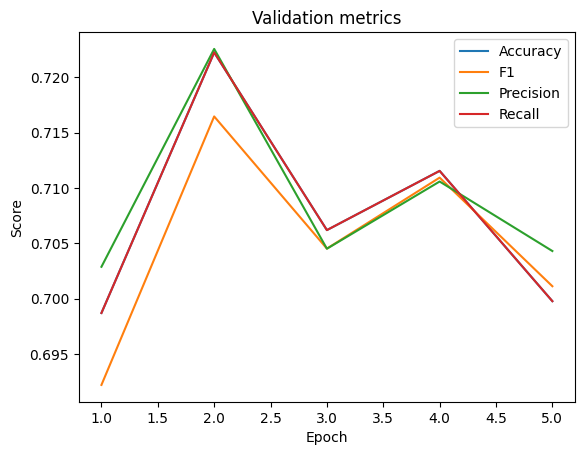

In [37]:
log_metrics = trainer.state.log_history
val_metrics = [log_metrics[i] for i in range(len(log_metrics)) if i % 2 == 1][:int(log_metrics[-1]['epoch'])]

val_acc = [m['eval_accuracy'] for m in val_metrics]
val_f1 = [m['eval_f1'] for m in val_metrics]
val_precision = [m['eval_precision'] for m in val_metrics]
val_recall = [m['eval_recall'] for m in val_metrics]
val_loss = [m['eval_loss'] for m in val_metrics]

fig, ax = plt.subplots()

epochs = np.arange(1, len(val_acc) + 1)

ax.plot(epochs, val_acc, label='Accuracy')
ax.plot(epochs, val_f1, label='F1')
ax.plot(epochs, val_precision, label='Precision')
ax.plot(epochs, val_recall, label='Recall')

ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Validation metrics')
ax.legend()
plt.show()

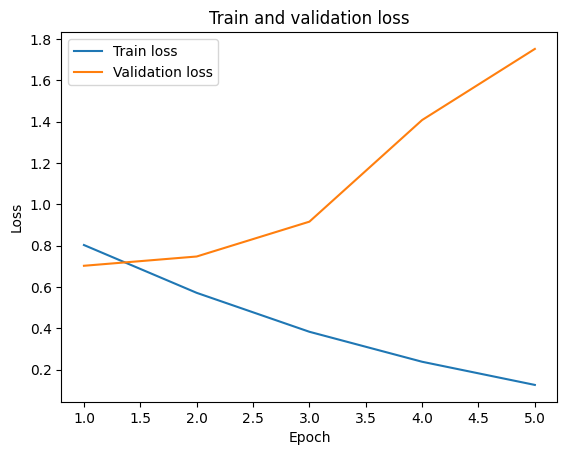

In [40]:
train_metrics = [log_metrics[i] for i in range(len(log_metrics)) if i % 2 == 0][:-1]

train_loss = [m['loss'] for m in train_metrics]

epochs = np.arange(1, len(val_acc) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Train loss')
ax.plot(epochs, val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and validation loss')
ax.legend()
plt.show()

## Load Best BERT Model

In [10]:
best_model = "checkpoint-5320" # Epoch = 2

### Test the model

In [44]:
best_bert = BertForSequenceClassification.from_pretrained('results/' + best_model)
# test on test set
predictions = trainer.predict(test_dataset)
predictions.metrics

test_acc = accuracy_score(y_test_sample, np.argmax(predictions.predictions, axis=1))
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test_sample, np.argmax(predictions.predictions, axis=1), average='macro')

print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test F1:', test_f1)

100%|██████████| 891/891 [00:23<00:00, 37.83it/s]

Test accuracy: 0.6680701754385965
Test precision: 0.6737024770843848
Test recall: 0.6680701754385966
Test F1: 0.6675729468334018


### Load as BERT Encoder

In [11]:
bert = BertModel.from_pretrained('results/' + best_model)

## Extract BERT embeddings for the dataset

In [59]:
def get_embeddings(model, dataset: TweetDataset, batch_size=16):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    i = 1
    for batch in loader:
        print(f'{i}/{len(loader)}', '\t'*3, end='\r')
        with torch.no_grad():
            batch.pop('labels')
            output = model(**batch)
            embeddings.append(output.last_hidden_state[:, 0, :].detach().numpy())
        i += 1
    print('\n\n')
    return np.concatenate(embeddings)

In [60]:
def save_emb_to_csv(emb, y, filename):
    df=pd.DataFrame(emb)
    df['label'] = y
    df.to_csv(filename, index=False)

print('Saving train embeddings...')
save_emb_to_csv(
    get_embeddings(bert, train_dataset),
    y_train_sample,
    'data/train_embeddings.csv'
)

print('Saving test embeddings...')
save_emb_to_csv(
    get_embeddings(bert, test_dataset),
    y_test_sample,
    'data/test_embeddings.csv'
)

print('Saving val embeddings...')
save_emb_to_csv(
    get_embeddings(bert, val_dataset),
    y_val_sample,
    'data/val_embeddings.csv'
)


Saving train embeddings...
1330/1330 			


Saving test embeddings...
446/446 			


Saving val embeddings...
59/59 			




## Load embeddings from CSV

In [14]:
train_emb = pd.read_csv('data/train_embeddings.csv')
test_emb = pd.read_csv('data/test_embeddings.csv')
val_emb = pd.read_csv('data/val_embeddings.csv')

In [15]:
train_emb

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,0.074619,-0.504215,-0.215037,0.120488,0.050080,-0.526661,0.040982,-0.582442,-1.267912,-0.247366,...,1.062318,-0.992902,-0.258879,1.122050,-0.493021,0.490082,1.505317,-0.407656,0.488354,2
1,0.111010,-0.615962,0.034875,0.178658,-0.185073,-0.688983,-0.036793,-0.714348,-1.751860,-0.203582,...,1.225037,-1.079208,-0.254121,1.023995,-0.625381,0.354577,1.566538,-0.325678,0.624409,2
2,0.628349,1.584097,-0.816622,0.283022,-0.296011,0.390125,-0.461798,0.268695,0.433820,-0.171577,...,0.338977,-0.626260,-0.539388,0.413617,-0.217488,0.766824,-0.662600,1.003275,-0.688229,0
3,-0.018245,-0.719434,-0.102599,0.617446,-0.409955,0.081359,0.003148,-0.405901,-0.195345,-0.328771,...,0.542947,-0.159760,-0.001092,0.325203,-0.105527,0.326793,0.353372,-0.494221,0.666118,1
4,0.167748,-1.033145,0.217278,0.111162,-0.268950,-0.366425,-0.350796,-0.582510,-0.552708,-0.223046,...,0.658390,-0.463134,0.112508,0.674263,-0.263382,0.581984,0.722690,-0.586417,0.834819,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21274,0.333284,-0.369120,-0.247308,0.111457,0.024653,-0.735427,-0.098743,-0.731291,-1.604813,0.040723,...,1.388230,-1.178581,-0.392684,1.435967,-0.462605,0.281227,1.820582,-0.438206,0.561417,2
21275,0.381722,-0.591006,-0.163812,0.423986,0.036124,-0.792008,-0.135527,-0.820892,-1.006837,-0.003011,...,1.061245,-1.168745,-0.487862,0.900669,-0.500574,0.628893,0.868254,-0.260256,0.422502,1
21276,-0.072119,-0.994433,0.050422,0.403382,0.004979,-0.031406,-0.008542,-0.688784,-0.741584,-0.368964,...,0.511733,-0.475885,-0.311978,0.506386,-0.403108,0.554971,0.723006,-0.387210,0.522352,2
21277,0.211273,-0.349692,-0.328207,0.321615,-0.146939,-0.299833,0.091532,-0.334499,-0.569444,-0.201500,...,0.616854,-0.560967,-0.179140,0.679045,-0.284448,0.327278,0.605033,-0.307340,0.591694,2


## LDA Decision Boundary Computation

In [17]:
X_train_emb, y_train_emb = train_emb.drop('label', axis=1), train_emb['label']

In [22]:
X_test_emb, y_test_emb = test_emb.drop('label', axis=1), test_emb['label']

In [21]:
N = X_train_emb.shape[0]
n_cl = len(np.unique(y_train_emb))
n_f = X_train_emb.shape[1]

N_t = np.array([np.sum(y_train_emb == i) for i in range (n_cl)])
mu_t = np.array([(1/N_t[i])*np.sum(X_train_emb[y_train_emb == i], axis=0)
             for i in range (n_cl)])

Mu = np.sum(mu_t,axis=0)/n_cl
mu_t_array = np.array([mu_t[int(y_train_emb[i])] for i in range(N)])

xmu = X_train_emb - mu_t_array

In [23]:
Sigma = xmu.T@xmu / (N-n_cl)

Sinv = np.linalg.inv(Sigma)
delta = np.array([np.log(N_t[i]/N)-(1/2) * mu_t[i].T @ Sinv @ mu_t[i]
                + X_test_emb @ Sinv @ mu_t[i] for i in range(n_cl)])

In [24]:
t_pred = np.argmax(delta,axis=0)

In [25]:
accuracy = np.sum(t_pred == y_test_emb)/len(y_test_emb)*100
print("Accuracy with Test:", accuracy.round(4),"%")

Accuracy with Test: 67.0737 %


## LDA Dimensionality Reduction

In [51]:
X = X_train_emb
y = y_train_emb

In [52]:
B=np.sum([N_t[i]*mu_t[i].reshape(-1,1)@mu_t[i].reshape(1,-1)
                   for i in range(n_cl)],0)

W = xmu.T @ xmu

L, P = np.linalg.eigh(np.linalg.inv(W)@B)

x_cent = X - Mu
PC2 = x_cent @ P
PC2 = PC2.to_numpy()

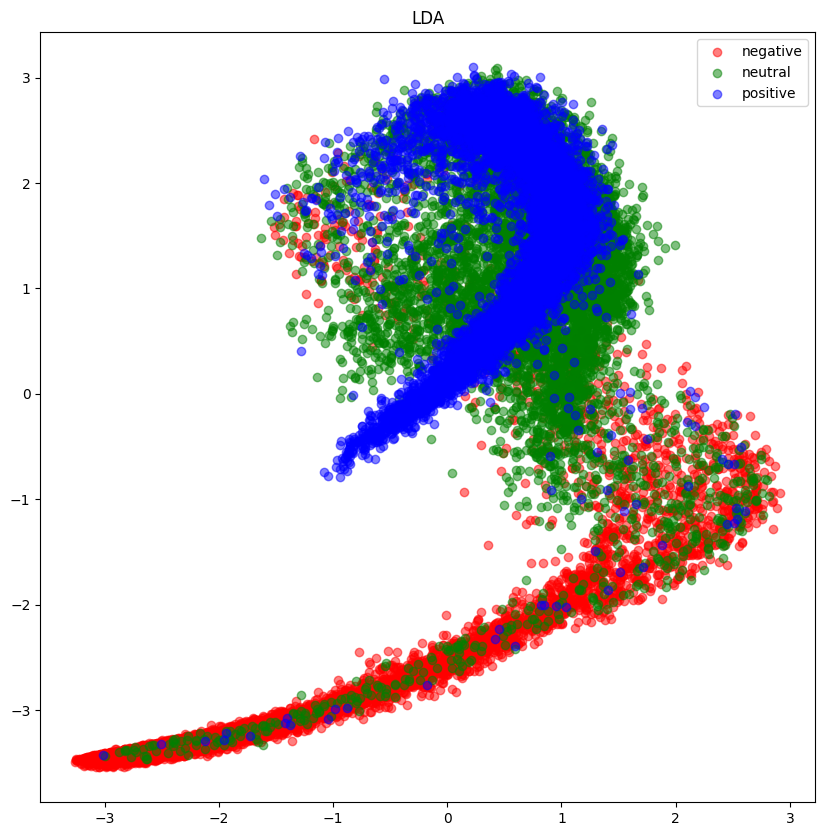

In [53]:
plt.figure(figsize=(10,10))
colors = ['r',"g",'b']
alphas = [0.5,0.5,0.5]
for i in range(n_cl):
    plt.scatter(PC2[y.to_numpy() == i, n_f - 1], PC2[y.to_numpy() == i, n_f - 2],
                c = colors[i], label = id2label[i], alpha=alphas[i])
plt.legend()
plt.title('LDA')

plt.show()

## Inference

/tmp/ipykernel_53760/2017792090.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


1/1 			


LDA predicts: positive


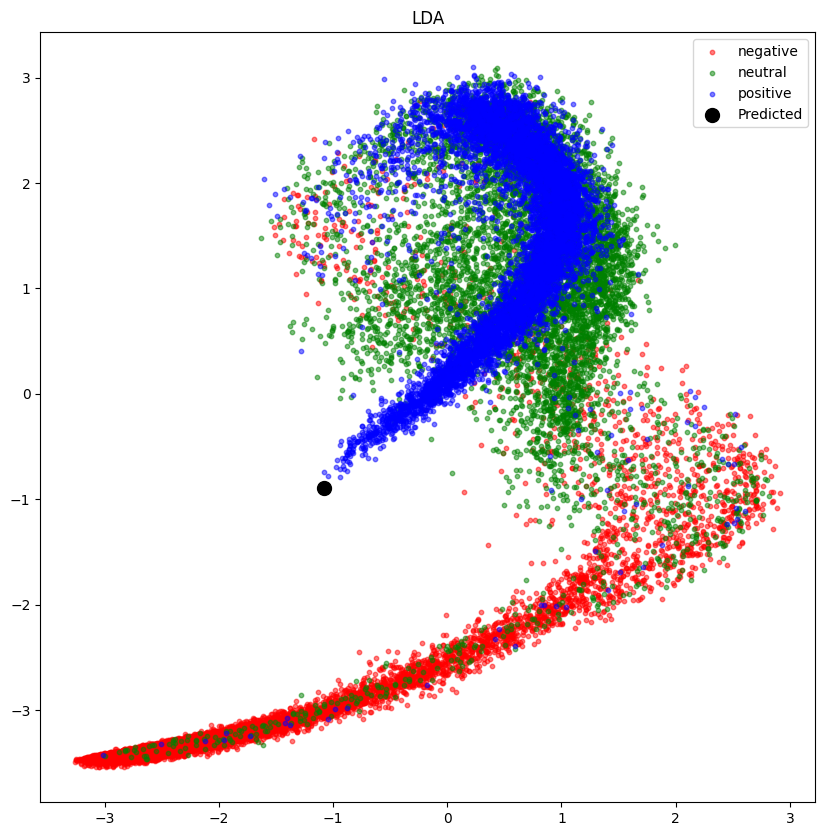

In [79]:
text = "I am so happy!"

# BERT embedding
encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
emb = get_embeddings(bert, TweetDataset(encodings, [0]))
features = emb[0]

# Reshaping
features = torch.tensor(features).float()
features = features.reshape(1, -1)

# LDA
Sigma = xmu.T@xmu / (N-n_cl)

Sinv = np.linalg.inv(Sigma)
delta = np.array([np.log(N_t[i]/N)-(1/2) * mu_t[i].T @ Sinv @ mu_t[i]
                + features @ Sinv @ mu_t[i] for i in range(n_cl)])

print("LDA predicts:", id2label[np.argmax(delta)]) # LDA prediction


# LDA Dimensionalty Reduction plot onto training data
X = X_train_emb
y = y_train_emb

X = np.vstack((X, features))
y = np.append(y, 3)

B=np.sum([N_t[i]*mu_t[i].reshape(-1,1)@mu_t[i].reshape(1,-1)
                   for i in range(n_cl)],0)

W = xmu.T @ xmu

L, P = np.linalg.eigh(np.linalg.inv(W)@B)

x_cent = X - Mu
PC2 = x_cent @ P
PC2 = PC2

plt.figure(figsize=(10,10))
colors = ['r',"g",'b', 'black']
alphas = [0.5,0.5,0.5,1.]

for i in range(n_cl+1):
    plt.scatter(PC2[y == i, n_f - 1], PC2[y == i, n_f - 2],
                c = colors[i], label = id2label[i] if i != 3 else 'Predicted', alpha=alphas[i], s=100 if i == 3 else 10)
plt.legend()
plt.title('LDA')

plt.show()